In [22]:
import netCDF4 as nc  # 或 from scipy.io import netcdf 如果是 NetCDF3
import numpy as np

from pyresample import geometry
from pyresample.bilinear import NumpyBilinearResampler
from pyresample._spatial_mp import cKDTree_MP
from pykdtree.kdtree import KDTree
from pyproj import CRS  # 新增导入 CRS
import xarray as xr

wgs84 = CRS.from_epsg(4326)  # EPSG:4326 为 WGS84 经纬度，等价于原字典

def read_data(f):
    with xr.open_dataset(f) as ds:
        X = ds["lon"].values
        Y = ds["lat"].values
        Z = ds["P"].values
        return X, Y, Z


def make_rast(extent=np.array([45, -60, 165, 60]), cellsize=0.05):
    xlims, ylims = extent[[0, 2]], extent[[1, 3]]
    # nx = int((xlims[1] - xlims[0]) / cellsize)
    # ny = int((ylims[1] - ylims[0]) / cellsize)
    lon = np.arange(xlims[0] + cellsize/2, xlims[1], cellsize)
    lat = np.arange(ylims[0] + cellsize/2, ylims[1], cellsize)

    target_def = geometry.AreaDefinition(
        'target_area', 'Regular lon-lat grid', proj_id='longlat',
        projection=wgs84,
        width=len(lon),  height=len(lat),
        area_extent=extent
    )
    return lon, np.flip(lat), target_def

In [23]:
f = 'FY4B_20250714014500_20250714015959.nc'
X, Y, Z = read_data(f)
X, Y, Z

(array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],
       shape=(2748, 2748), dtype=float32),
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],
       shape=(2748, 2748), dtype=float32),
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],
       shape=(2748, 2748), dtype=float32))

In [ ]:
xx, yy, target_def = make_rast()
xx, yy, target_def

(array([ 45.025,  45.075,  45.125, ..., 164.875, 164.925, 164.975],
       shape=(2400,)),
 array([ 59.975,  59.925,  59.875, ..., -59.875, -59.925, -59.975],
       shape=(2400,)),
 Area ID: target_area
 Description: Regular lon-lat grid
 Projection ID: longlat
 Projection: {'datum': 'WGS84', 'no_defs': 'None', 'proj': 'longlat', 'type': 'crs'}
 Number of columns: 2400
 Number of rows: 2400
 Area extent: (np.int64(45), np.int64(-60), np.int64(165), np.int64(60)))

In [5]:
source_def = geometry.SwathDefinition(lons=X, lats=Y)
resampler = NumpyBilinearResampler(source_def, target_def, 4000*4) # radius_of_influence, 4km * 3

nprocs = 10
kdtree_class = cKDTree_MP if nprocs > 1  else KDTree
resampler.get_bil_info(kdtree_class=kdtree_class, nprocs=nprocs)

c:\Users\hydro\miniforge3\Lib\site-packages\pyproj\crs\crs.py:1295: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
c:\Users\hydro\miniforge3\Lib\site-packages\pyresample\bilinear\_base.py:395: RuntimeWarning: invalid value encountered in divide
  x_1 = (-b__ + np.sqrt(discriminant)) / (2 * a__)
c:\Users\hydro\miniforge3\Lib\site-packages\pyresample\bilinear\_base.py:396: RuntimeWarning: divide by zero encountered in divide
  x_2 = (-b__ - np.sqrt(discriminant)) / (2 * a__)
c:\Users\hydro\miniforge3\Lib\site-packages\pyresample\bilinear\_base.py:462: RuntimeWarning: divide by zero encountered in divide
  g__ = ((out_y - y_1 - y_21 * f__) /
c:\Users\hydro\miniforge3\Lib\site-packages\pyresample\bilinear\_base.py:462: RuntimeWarning: invalid value encountered in divide
  g__

In [ ]:
%%time
# ntime = 100 # 1month
# Z = np.random.rand(nx, ny, ntime)  # 示例数据
# data = np.transpose(Z, (2, 0, 1))  # (ntime, nx, ny)
Z2 = resampler.get_sample_from_bil_info(Z, fill_value=np.nan, output_shape=None)
Z2.shape

CPU times: total: 469 ms
Wall time: 469 ms


(2400, 2400)

In [ ]:
da = xr.DataArray(
    Z2,
    dims=['lon', 'lat'],  # 维度名称（可自定义，如'longitude'）
    coords={'lon': xx, 'lat': yy },
    attrs = {"unit": "mm/h"}, 
    name='Precipiation'
)
da.to_netcdf("result_v2.nc")

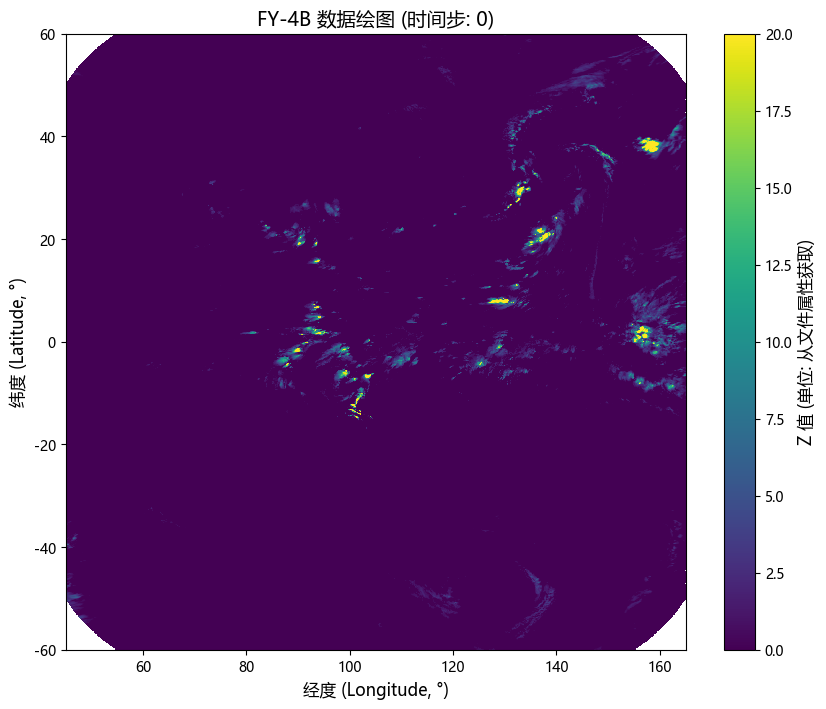

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm  # 用于颜色映射

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 或 ['Microsoft YaHei', 'DejaVu Sans'] 以 fallback
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 绘图（假设绘第一个时间步）
t = 0  # 时间索引，从 0 到 ntime-1
fig, ax = plt.subplots(figsize=(10, 8))  # 创建画布

# 伪彩色网格图
pcm = ax.pcolormesh(xx, np.flip(yy), resampled_Z, cmap=cm.viridis, shading='auto')  # shading='auto' 自动处理边界
# 添加颜色条
cbar = plt.colorbar(pcm, ax=ax, orientation='vertical', pad=0.05)
cbar.set_label('Z 值 (单位: 从文件属性获取)', fontsize=12)

# 设置轴标签和标题
ax.set_xlabel('经度 (Longitude, °)', fontsize=12)
ax.set_ylabel('纬度 (Latitude, °)', fontsize=12)
ax.set_title(f'FY-4B 数据绘图 (时间步: {t})', fontsize=14)

# # 限制轴范围（可选，根据数据）
# ax.set_xlim(np.min(X), np.max(X))
# ax.set_ylim(np.min(Y), np.max(Y))

# 显示或保存
plt.show()  # 或 plt.savefig('plot.png', dpi=300)